In [1]:
from copy import deepcopy
import numpy as np
from process_bigraph import Composite
from process_bigraph import allocate_core
from process_bigraph.emitter import gather_emitter_results, emitter_from_wires

from cdFBA.data_types import register_types
from cdFBA.processes.dfba import dFBA, UpdateEnvironment, StaticConcentration, Injector, WaveFunction

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_static_spec, set_concentration, \
    set_kinetics, model_from_file, SHARED_ENVIRONMENT

from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
#Create a model dictionary. The keys should be the names of the individual dFBA models/species and the values should be
#BiGG model ids or the path name to the associated model file
model_dict = {
    "Prochlorococcus": "iSO595v7.xml",
}
#list exchange reactions
exchanges = ["LightEX"]
#set environment volume
volume=2
# define a single dFBA model
spec = make_cdfba_composite(model_dict, medium_type=None, exchanges=exchanges, volume=volume, interval=0.1)
# #print spec
pprint(spec)

{'Shared Environment': {'concentrations': {'Photon': 10.0,
                                           'Prochlorococcus': 0.25},
                        'counts': {'Photon': 20, 'Prochlorococcus': 0.5},
                        'volume': 2},
 'Species': {'Prochlorococcus': {'_type': 'process',
                                 'address': 'local:dFBA',
                                 'config': {'bounds': {},
                                            'changes': {'bounds': {},
                                                        'gene_knockout': [],
                                                        'kinetics': {},
                                                        'reaction_knockout': []},
                                            'kinetics': {'Photon': (0.5, 2.0)},
                                            'medium': {},
                                            'model_file': 'iSO595v7.xml',
                                            'name': 'Prochlorococcus',
       

In [3]:
#configure wave_function process
wave_config = {
    "substrate_params": {
        "Photon": {
            "amplitude": 5,
            "angular_frequency": 1/np.pi,
            "base_concentration": 0,
            "phase_shift": 0
        }
    }
}
spec = deepcopy(spec)
spec['Wave Function'] = get_wave_spec(wave_config, interval=0.1)

#set external substrate concentrations
concentrations = {
    "Photon": 0
}
set_concentration(spec, concentrations)

In [4]:
#set emitter specs
spec['emitter'] = emitter_from_wires({
        "global_time": ["global_time"],
        "shared_environment": [SHARED_ENVIRONMENT],
    })

In [5]:
#create the core object
core = allocate_core(spec)
#register data types
core = register_types(core)
#register all processes and steps
core.register_link('dFBA', dFBA)
core.register_link('UpdateEnvironment', UpdateEnvironment)
core.register_link('StaticConcentration', StaticConcentration)
core.register_link('WaveFunction', WaveFunction)
core.register_link('Injector', Injector)

In [6]:
sim = Composite(
    {
        "state": spec,
    },
    core=core
)

In [7]:
#run simulation
sim.run(40)

/opt/anaconda3/envs/dfba/lib/python3.14/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [8]:
#gather results
results = gather_emitter_results(sim)[('emitter',)]

In [9]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

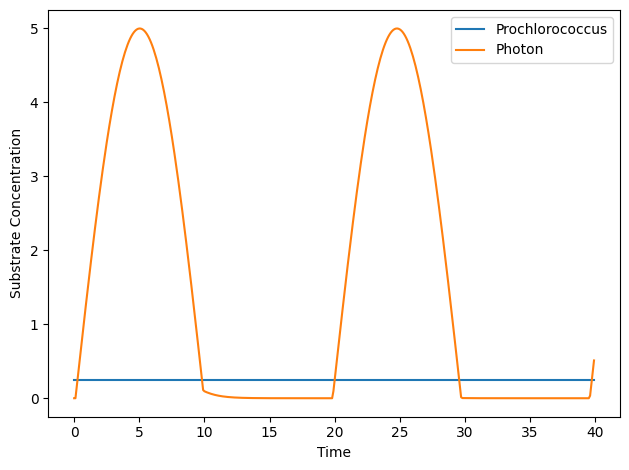

In [10]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
model = model_from_file("iSO595v7.xml")

In [12]:
[met.id for met in model.reactions.get_by_id("LightEX").metabolites]

['Photon[e]']

In [13]:
[reaction.reaction for reaction in model.metabolites.get_by_id("Photon[e]").reactions]

['0.02 ATP[c] + Photon[e] --> 0.02 ADP[c] + 0.02 Orthophosphate[c] + Photon[c]',
 'Photon[e] --> Photon[c]',
 'Photon[e] <=> ']